Current CV =  2
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}
Test set accuracy: 0.652
              precision    recall  f1-score   support

    negative       0.64      0.73      0.68       129
    positive       0.66      0.57      0.61       121

    accuracy                           0.65       250
   macro avg       0.65      0.65      0.65       250
weighted avg       0.65      0.65      0.65       250

Linear Results
Accuracy Score:  0.652
F1- Score:  0.6133333333333333
Recall:  0.5702479338842975
Precision:  0.6634615384615384
[[94 35]
 [52 69]]
              precision    recall  f1-score   support

    negative       0.64      0.73      0.68       129
    positive       0.66      0.57      0.61       121

    accuracy                           0.65       250
   macro avg       0.65      0.65      0.65       250
weighted avg       0.65      0.65      0.65       250

Current CV =  3
Best hyperp

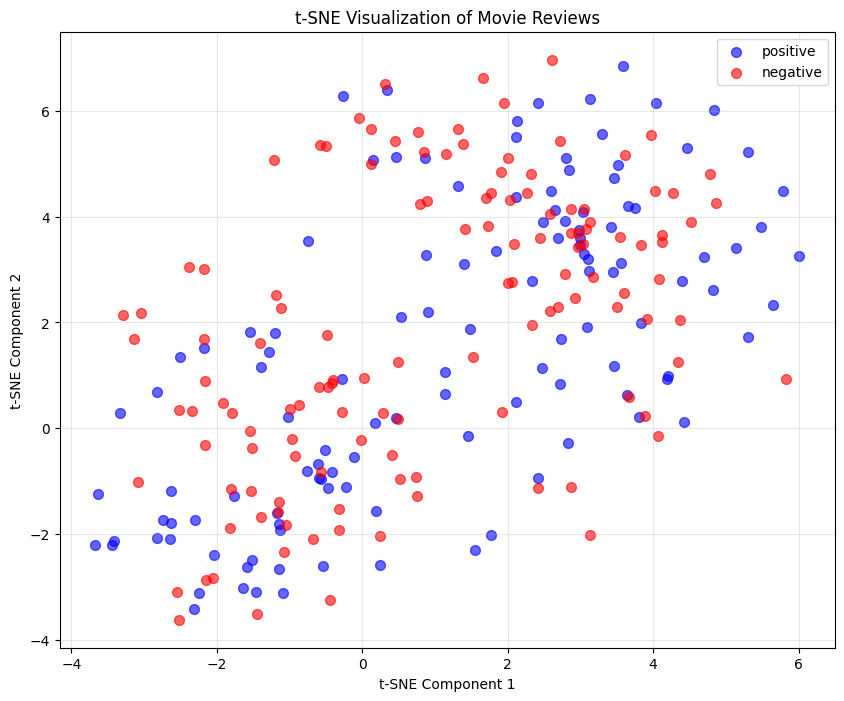

1. LDA_Topic_45: 0.2044
2. LDA_Topic_30: 0.1284
3. LDA_Topic_23: 0.1122


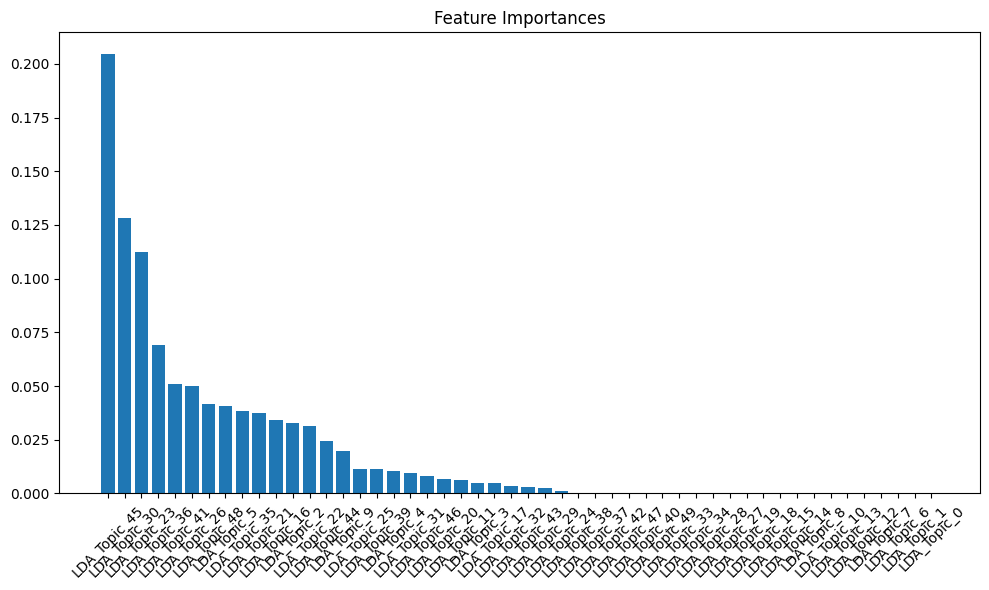

Best results
Best report               precision    recall  f1-score   support

    negative       0.64      0.82      0.72       129
    positive       0.73      0.51      0.60       121

    accuracy                           0.67       250
   macro avg       0.69      0.67      0.66       250
weighted avg       0.68      0.67      0.66       250

Best acc 0.672
Best estimator RandomForestClassifier(max_depth=3, n_estimators=10)
Best cv:  3
Auc_Score:  0.7366263053366648


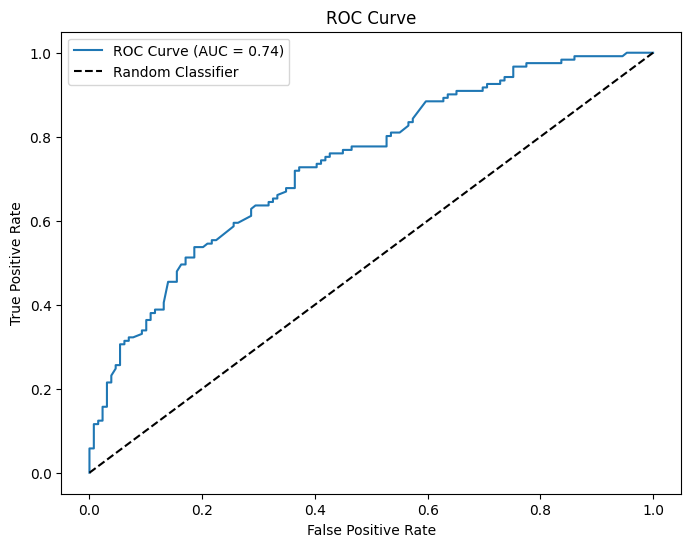

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
import lime
import lime.lime_tabular

df = pd.read_csv('Movie_Reviews.csv', nrows=1000)
trainReviews = df['review']
target = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(trainReviews, target, test_size=0.25, random_state=42)

count_vectorizer = CountVectorizer(
    max_features=2000,
    stop_words='english',
    max_df=0.95,
    min_df=2
)

X_train_vectorized = count_vectorizer.fit_transform(X_train)
X_test_vectorized = count_vectorizer.transform(X_test)


lda = LatentDirichletAllocation(
    n_components=50,          
    random_state=42,
    max_iter=100,
    learning_method='batch',  
    learning_decay=0.7,
    learning_offset=50.0,
    doc_topic_prior=None,     
    topic_word_prior=None,    
    n_jobs=-1                 
)

lda_X_train = lda.fit_transform(X_train_vectorized)
lda_X_test = lda.transform(X_test_vectorized)
 
best_acc = -1
best_cv = 0
best_report = None
best_estimator = None
best_y_pred = None
best_y_test= None

def Predict_And_Plot_Results(X_train, X_test, y_train, y_test):
    
    global best_acc
    global best_cv
    global best_report
    global best_estimator
    global best_y_pred
    global best_y_test
    
    rf = RandomForestClassifier()

    param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5, 10, 15, 20, None],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2,5,10,25]
    }

    for cv in range(2, 10):
        print("Current CV = ", cv)

        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        print("Best hyperparameters:", grid_search.best_params_)

        best_rf = grid_search.best_estimator_
        score =  best_rf.score(X_test, y_test)
        print("Test set accuracy:", score)
    
        y_pred = best_rf.predict(X_test)
        report = classification_report(y_test, y_pred)
        print(report)

        score = accuracy_score(y_test, y_pred)
        conf_mtx = confusion_matrix(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, pos_label='positive')
        recall = recall_score(y_test, y_pred,pos_label='positive')
        precision = precision_score(y_test, y_pred,pos_label='positive')
    
        if score > best_acc:
           best_acc = score
           best_estimator = grid_search.best_estimator_
           best_report = report
           best_cv = cv
           best_y_pred = y_pred
           best_y_test = y_test
  
    
        print("Linear Results")
        print("Accuracy Score: ", score)
        print("F1- Score: ", f1)
        print("Recall: ",recall)
        print("Precision: ", precision)
        print(conf_mtx)
        print(report)
    
    
Predict_And_Plot_Results(lda_X_train, lda_X_test, y_train, y_test)

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random',verbose=True).fit_transform(X_test_vectorized)

plt.figure(figsize=(10, 8))

colors = {'positive': 'blue', 'negative': 'red'}
for sentiment in colors:
    mask = y_test == sentiment
    plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], 
               c=colors[sentiment], label=sentiment, alpha=0.6, s=50)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Movie Reviews')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

y_proba = best_estimator.predict_proba(lda_X_test)

sentiment_mapping = {'positive': 1, 'negative': 0} 
mapped_y_test = best_y_test.map(sentiment_mapping)

fpr, tpr, thresholds = roc_curve(mapped_y_test, y_proba[:, 1])
auc_score = roc_auc_score(mapped_y_test, y_proba[:, 1])

importances = best_estimator.feature_importances_
feature_names = [f"LDA_Topic_{i}" for i in range(len(importances))]

indices = np.argsort(importances)[::-1]

for i in range(0,3):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

explainer = lime.lime_tabular.LimeTabularExplainer(
lda_X_train,
feature_names=feature_names,
class_names=['positive', 'negative'],
mode='classification'
)
check = lda_X_test[0]
check_01 = lda_X_test[1]
explanation = explainer.explain_instance(
    check,  
    best_estimator.predict_proba,   
    num_features=10         
)

explanation.save_to_file('example1.html')
explanation = explainer.explain_instance(
    check_01,  
    best_estimator.predict_proba,   
    num_features=10        
)

explanation.save_to_file('example2.html')

print("Best results")
print("Best report",best_report)
print("Best acc",best_acc)
print("Best estimator",best_estimator)
print("Best cv: ", best_cv)
print("Auc_Score: ", auc_score)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()